In [2]:
import os
import pandas as pd
import numpy as np

# CSV 폴더 경로
csv_dir = "/home/avees/tee/output"

# 라벨별로 값 누적
label_data = {}

# 폴더 내 CSV 파일들 읽기
csv_files = [f for f in os.listdir(csv_dir) if f.endswith(".csv")]

for filename in sorted(csv_files):
    file_path = os.path.join(csv_dir, filename)
    try:
        df = pd.read_csv(file_path)
        for col in df.columns:
            values = df[col].dropna().astype(float).tolist()
            if not values:
                continue
            if col not in label_data:
                label_data[col] = []
            label_data[col].extend(values)
    except Exception as e:
        print(f"⚠️ {filename} 읽기 실패: {e}")

# 라벨별 통계 계산
summary_rows = []
for label, values in label_data.items():
    sorted_vals = sorted(values, reverse=True)
    max_val = sorted_vals[0]
    max2_val = sorted_vals[4] if len(sorted_vals) > 4 else np.nan
    min_val = sorted_vals[-1]
    mean_val = np.nan
    if len(sorted_vals) > 1:
        mean_val = np.mean(sorted_vals[5:])  # 최대값 제외 평균

    summary_rows.append({
        "label": label,
        "count": len(values),
        "max": max_val,
        "max5": max2_val,
        "min": min_val,
        "mean(exclude_max)": mean_val
    })

# DataFrame으로 변환 및 저장
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="label")

output_path = os.path.join(csv_dir, "output_merged.csv")
summary_df.to_csv(output_path, index=False)

print(f"\n✅ 모든 파일 통합 라벨별 통계 완료 → {output_path}")
print(f"총 {len(summary_df)}개 라벨 계산됨")



✅ 모든 파일 통합 라벨별 통계 완료 → /home/avees/tee/output/output_merged.csv
총 166개 라벨 계산됨


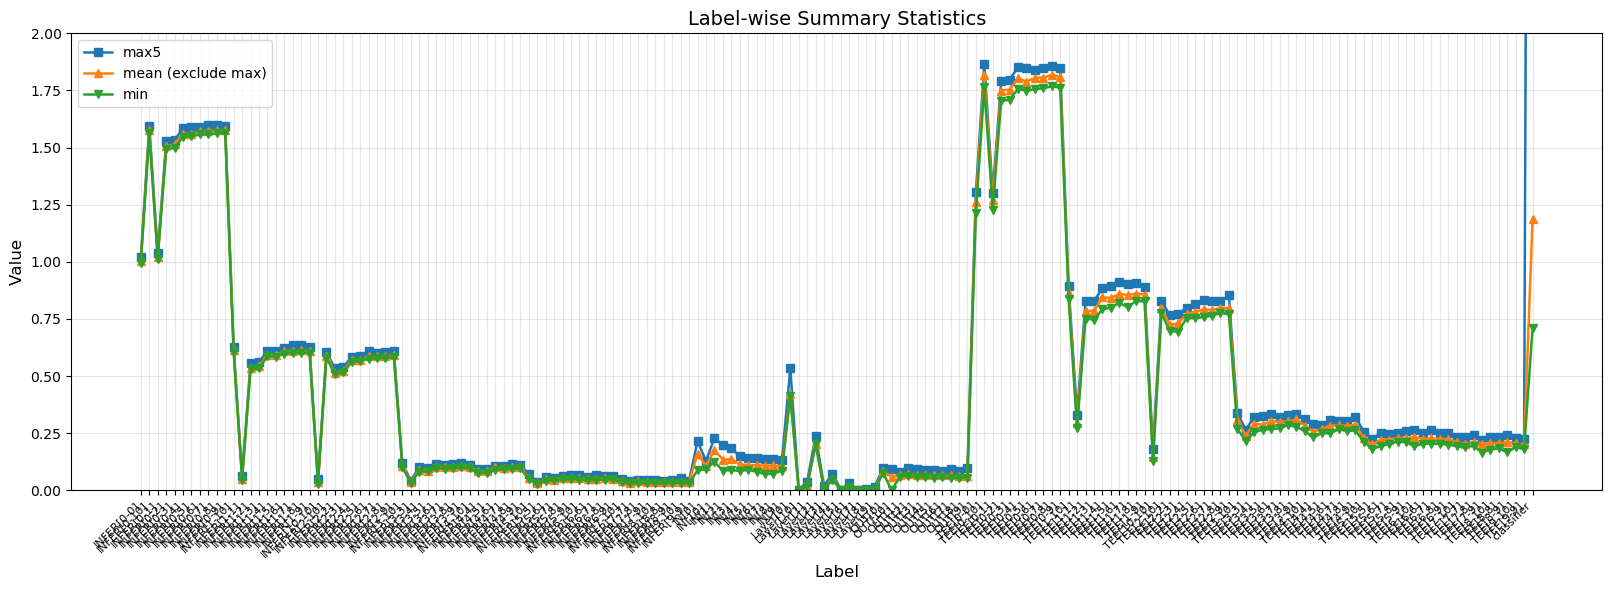

✅ 그래프 저장 완료: /home/avees/tee/output/summary_plot.png


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 정리된 CSV 파일 경로
csv_path = "/home/avees/tee/output/output_merged.csv"

# CSV 파일 읽기
df = pd.read_csv(csv_path)

# 컬럼 이름 통일 (mean 컬럼 이름이 괄호 때문에 처리 어려울 수 있어 수정)
df.rename(columns={"mean(exclude_max)": "mean"}, inplace=True)

# 그래프 설정
plt.figure(figsize=(16, 6))
x = np.arange(len(df["label"]))  # 라벨 개수만큼 x축 인덱스

# 각 통계값 plot
plt.plot(x, df["max5"], marker='s', label='max5', linewidth=1.8)
plt.plot(x, df["mean"], marker='^', label='mean (exclude max)', linewidth=1.8)
plt.plot(x, df["min"], marker='v', label='min', linewidth=1.8)

# 시각적 세부 설정
plt.xticks(x, df["label"], rotation=45, ha='right', fontsize=8)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Label-wise Summary Statistics", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# 저장 및 출력
output_png = os.path.join(os.path.dirname(csv_path), "summary_plot.png")
plt.savefig(output_png, dpi=300)
plt.ylim(0, 2)
plt.show()

print(f"✅ 그래프 저장 완료: {output_png}")


✅ TEE 라벨 개수: 11
✅ LAYER 라벨 개수: 11


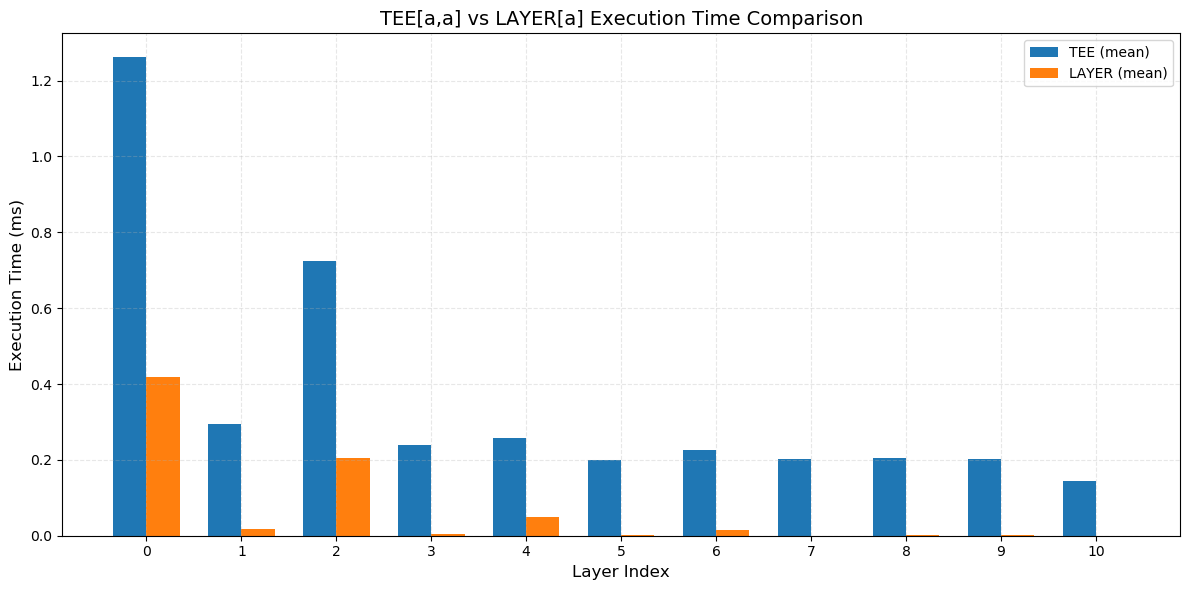

✅ 그래프 저장 완료: /home/avees/tee/output/tee_layer_indexed_comparison.png


In [20]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 파일 경로
csv_path = "/home/avees/tee/output/output_merged.csv"

# CSV 읽기
df = pd.read_csv(csv_path)
df.rename(columns={"mean(exclude_max)": "mean"}, inplace=True)

# 🔹 TEE, LAYER 라벨만 필터링 (대소문자 무시)
df = df[df["label"].str.contains("TEE|LAYER", case=False, na=False)].copy()

# 🔹 라벨에서 index 추출
def extract_index(label):
    label = label.upper()
    # TEE[a-a] 형식
    m1 = re.search(r"TEE\[(\d+)-\1\]", label)
    # LAYER[a] 또는 LAYER[a-a] 형식
    m2 = re.search(r"LAYER\[(\d+)(?:-\1)?\]", label)
    if m1:
        return int(m1.group(1))
    elif m2:
        return int(m2.group(1))
    return None

df["index"] = df["label"].apply(extract_index)
df = df.dropna(subset=["index"]).copy()
df["index"] = df["index"].astype(int)

# 🔹 분리
tee_df = df[df["label"].str.contains("TEE", case=False)]
layer_df = df[df["label"].str.contains("LAYER", case=False)]

print(f"✅ TEE 라벨 개수: {len(tee_df)}")
print(f"✅ LAYER 라벨 개수: {len(layer_df)}")

# 🔹 X축 범위 (0~10)
x_labels = list(range(0, 11))
x = np.arange(len(x_labels))
width = 0.35

tee_y, layer_y = [], []

for i in x_labels:
    tee_row = tee_df[tee_df["index"] == i]
    layer_row = layer_df[layer_df["index"] == i]

    tee_val = tee_row["mean"].values[0] if not tee_row.empty else np.nan
    layer_val = layer_row["mean"].values[0] if not layer_row.empty else np.nan

    tee_y.append(tee_val)
    layer_y.append(layer_val)

# 🔹 그래프
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, tee_y, width=width, label="TEE (mean)", color="#1f77b4")
plt.bar(x + width/2, layer_y, width=width, label="LAYER (mean)", color="#ff7f0e")

plt.xticks(x, x_labels)
plt.xlabel("Layer Index", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)
plt.title("TEE[a,a] vs LAYER[a] Execution Time Comparison", fontsize=14)
plt.legend()
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()

# 저장
output_png = os.path.join(os.path.dirname(csv_path), "tee_layer_indexed_comparison.png")
plt.savefig(output_png, dpi=300)
plt.show()

print(f"✅ 그래프 저장 완료: {output_png}")


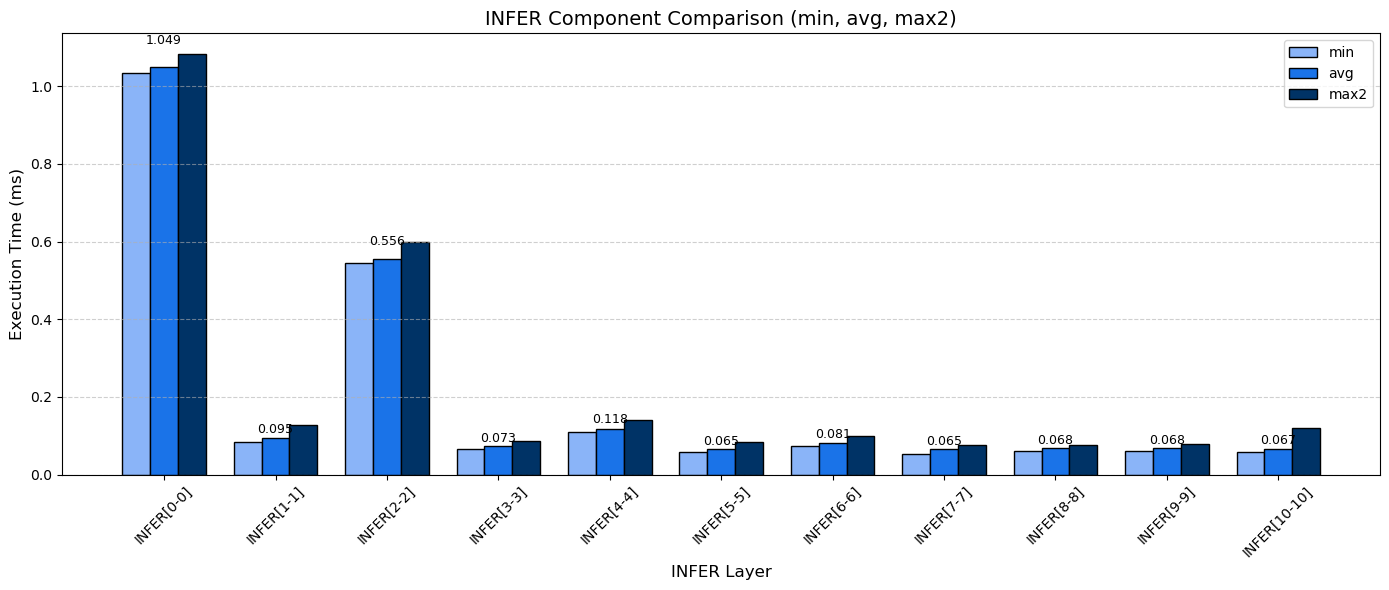

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 파일 경로
csv_path = "/home/avees/tee/graph/component/src/INFER.csv"

# CSV 읽기
df = pd.read_csv(csv_path, index_col=0)

# 사용할 행 선택 (순서: min → avg → max2)
selected_rows = ['min', 'avg', 'max2']
df_selected = df.loc[selected_rows]

# 라벨 (x축)
labels = df.columns.tolist()
x = np.arange(len(labels))  # x 위치

# 막대 폭
width = 0.25

plt.figure(figsize=(14, 6))

# 동일한 hue에 채도만 다른 색상
colors = ['#8ab4f8', '#1a73e8', '#003366']  # 밝은 파랑 → 중간 → 진한 네이비

# 막대 그래프
bars_min = plt.bar(x - width, df_selected.loc['min'], width,
                   label='min', color=colors[0], edgecolor='black')
bars_avg = plt.bar(x, df_selected.loc['avg'], width,
                   label='avg', color=colors[1], edgecolor='black')
bars_max2 = plt.bar(x + width, df_selected.loc['max2'], width,
                    label='max2', color=colors[2], edgecolor='black')

# avg 막대 위에 값 표시
for i, v in enumerate(df_selected.loc['avg']):
    plt.text(x[i], v + (v * 0.05), f"{v:.3f}", ha='center', va='bottom', fontsize=9)

# 시각적 설정
plt.title("INFER Component Comparison (min, avg, max2)", fontsize=14)
plt.ylabel("Execution Time (ms)", fontsize=12)
plt.xlabel("INFER Layer", fontsize=12)
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


📊 Processing: IN.csv


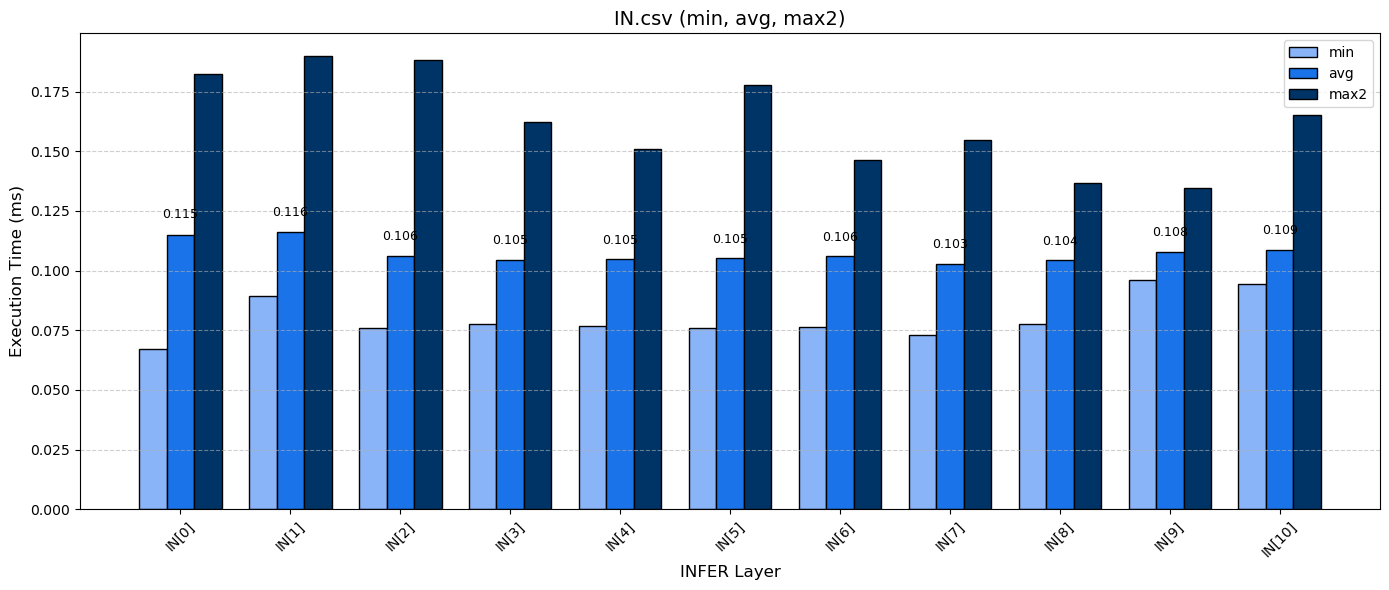

✅ Saved: /home/avees/tee/graph/component/src/IN.png
📊 Processing: INFER.csv


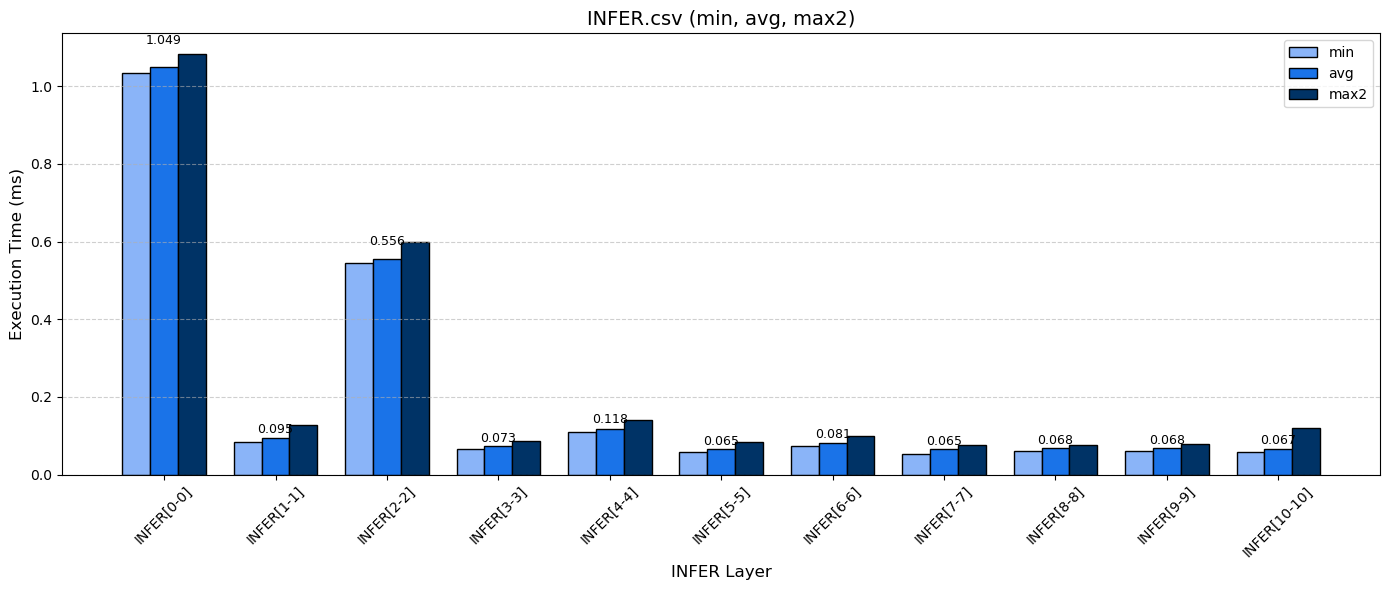

✅ Saved: /home/avees/tee/graph/component/src/INFER.png
📊 Processing: LAYER.csv


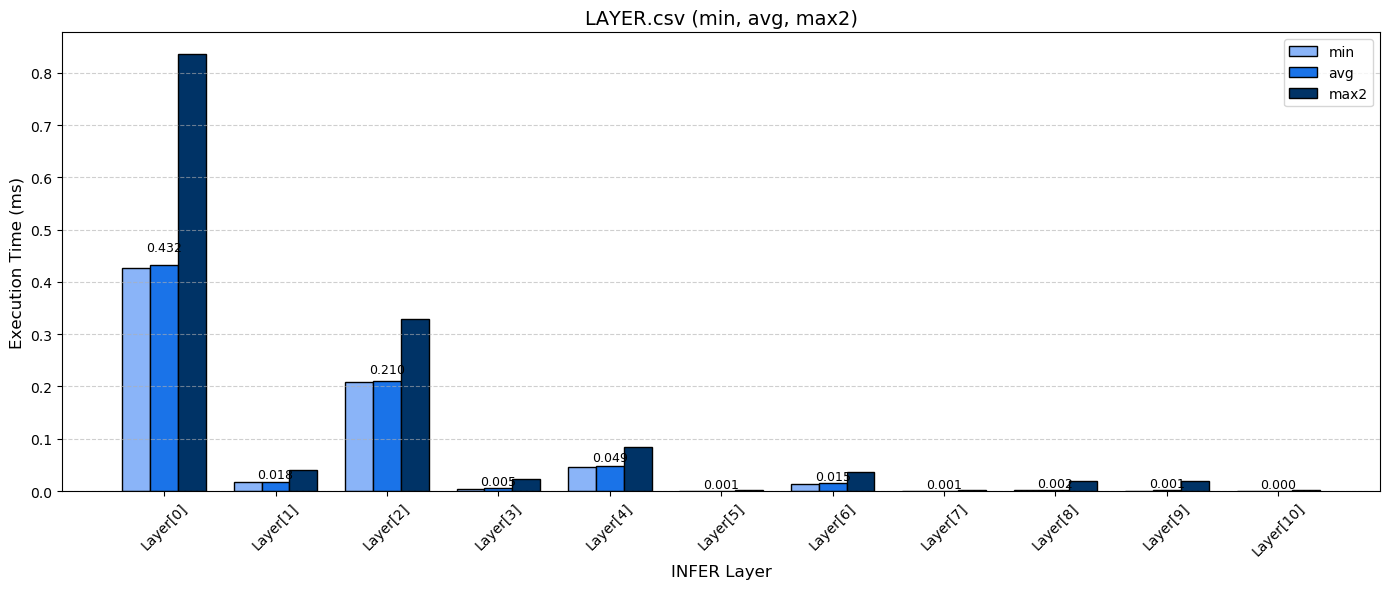

✅ Saved: /home/avees/tee/graph/component/src/LAYER.png
📊 Processing: OUT.csv


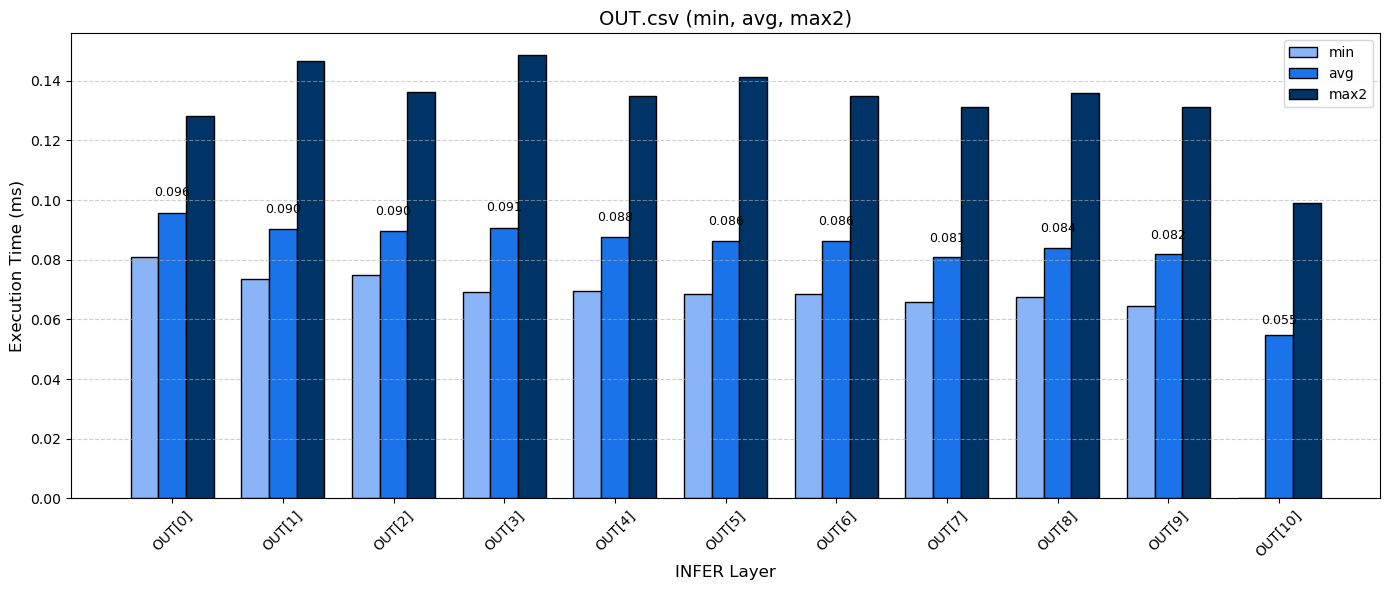

✅ Saved: /home/avees/tee/graph/component/src/OUT.png
📊 Processing: TEE.csv


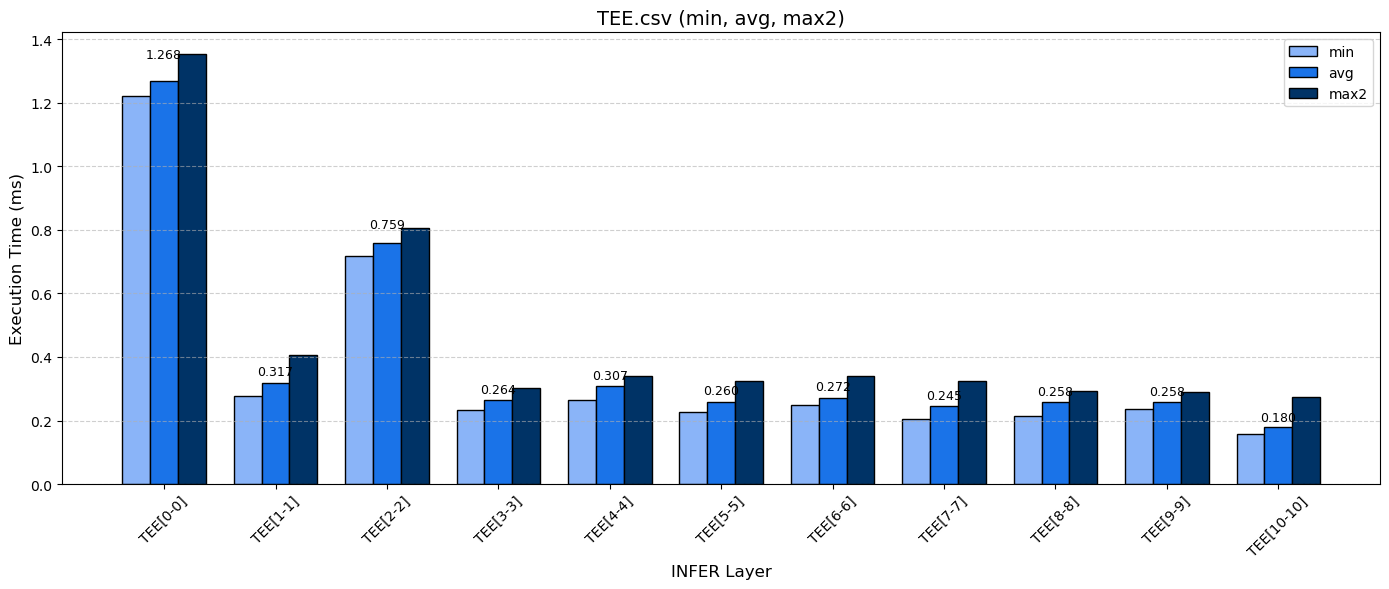

✅ Saved: /home/avees/tee/graph/component/src/TEE.png
📊 Processing: merged.csv


/home/avees/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


TypeError: nan is not a string

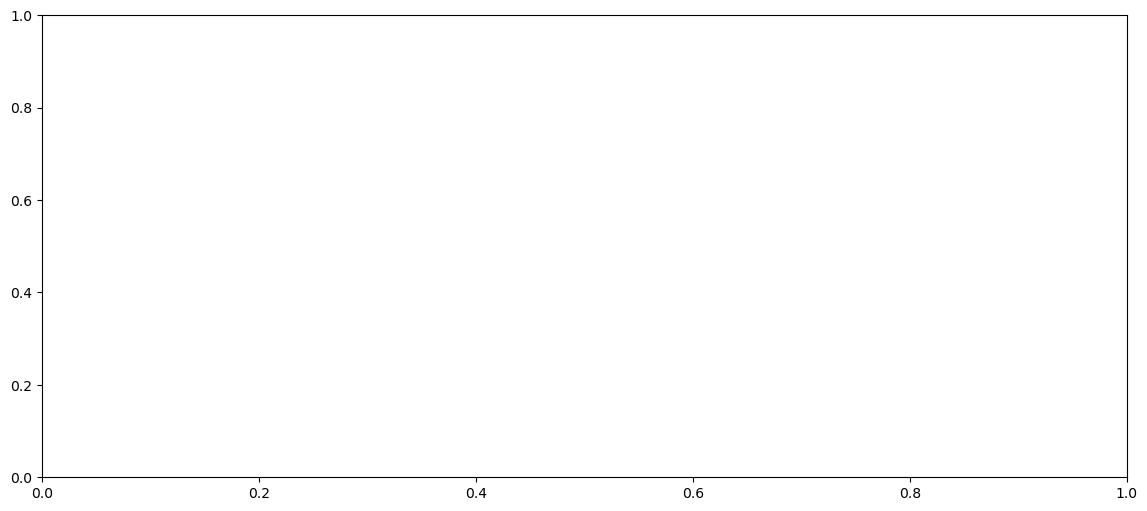

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 폴더 경로
csv_dir = "/home/avees/tee/graph/component/src"

# 동일한 hue에 채도만 다른 색상
colors = ['#8ab4f8', '#1a73e8', '#003366']  # 밝은 파랑 → 중간 → 진한 네이비

# 폴더 내 모든 CSV 파일 순회
for filename in sorted(os.listdir(csv_dir)):
    if not filename.endswith(".csv"):
        continue

    csv_path = os.path.join(csv_dir, filename)
    print(f"📊 Processing: {filename}")

    # CSV 읽기
    df = pd.read_csv(csv_path, index_col=0)

    # 사용할 행 선택 (순서: min → avg → max2)
    selected_rows = ['min', 'avg', 'max2']

    # 필요한 행이 모두 존재하지 않으면 건너뜀
    if not all(row in df.index for row in selected_rows):
        print(f"⚠️  Skipped {filename}: required rows missing ({selected_rows})")
        continue

    df_selected = df.loc[selected_rows]

    # 라벨 (x축)
    labels = df.columns.tolist()
    x = np.arange(len(labels))  # x 위치

    # 막대 폭
    width = 0.25

    plt.figure(figsize=(14, 6))

    # 막대 그래프
    plt.bar(x - width, df_selected.loc['min'], width,
            label='min', color=colors[0], edgecolor='black')
    plt.bar(x, df_selected.loc['avg'], width,
            label='avg', color=colors[1], edgecolor='black')
    plt.bar(x + width, df_selected.loc['max2'], width,
            label='max2', color=colors[2], edgecolor='black')

    # avg 막대 위에 값 표시
    for i, v in enumerate(df_selected.loc['avg']):
        plt.text(x[i], v + (v * 0.05), f"{v:.3f}", ha='center', va='bottom', fontsize=9)

    # 시각적 설정
    plt.title(f"{filename} (min, avg, max2)", fontsize=14)
    plt.ylabel("Execution Time (ms)", fontsize=12)
    plt.xlabel("INFER Layer", fontsize=12)
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # PNG 파일로 저장 (같은 폴더에)
    png_path = os.path.join(csv_dir, os.path.splitext(filename)[0] + ".png")
    plt.show()
    # plt.savefig(png_path, dpi=300)
    plt.close()

    print(f"✅ Saved: {png_path}")


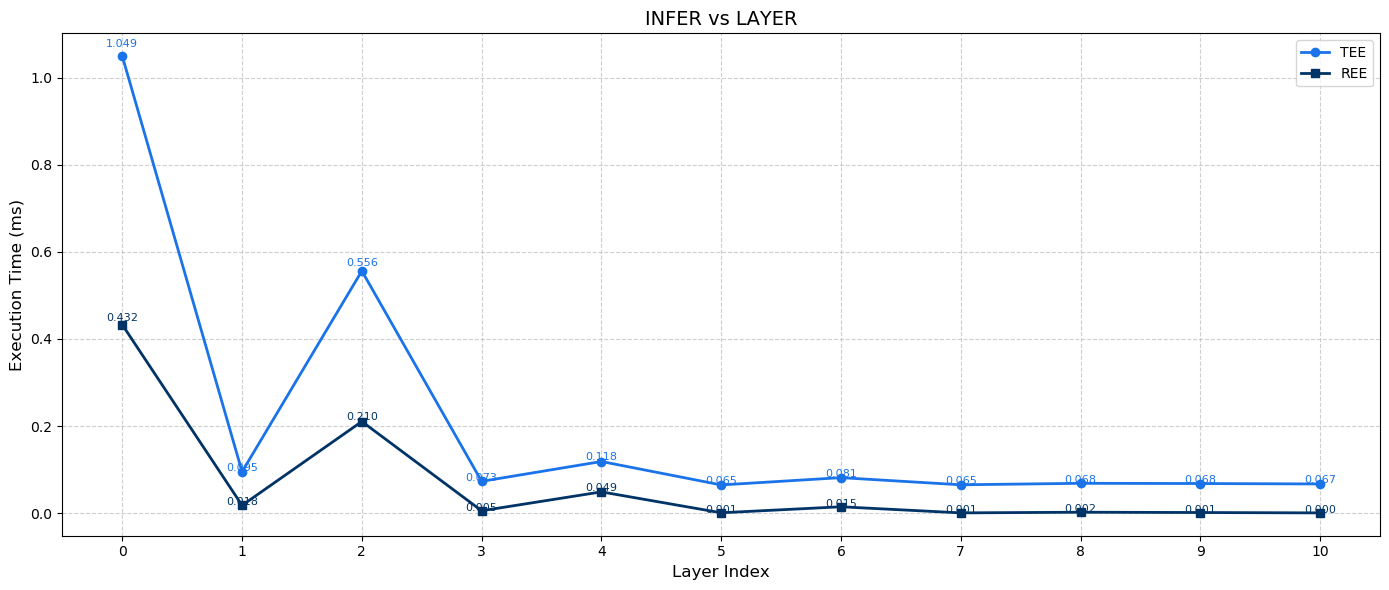

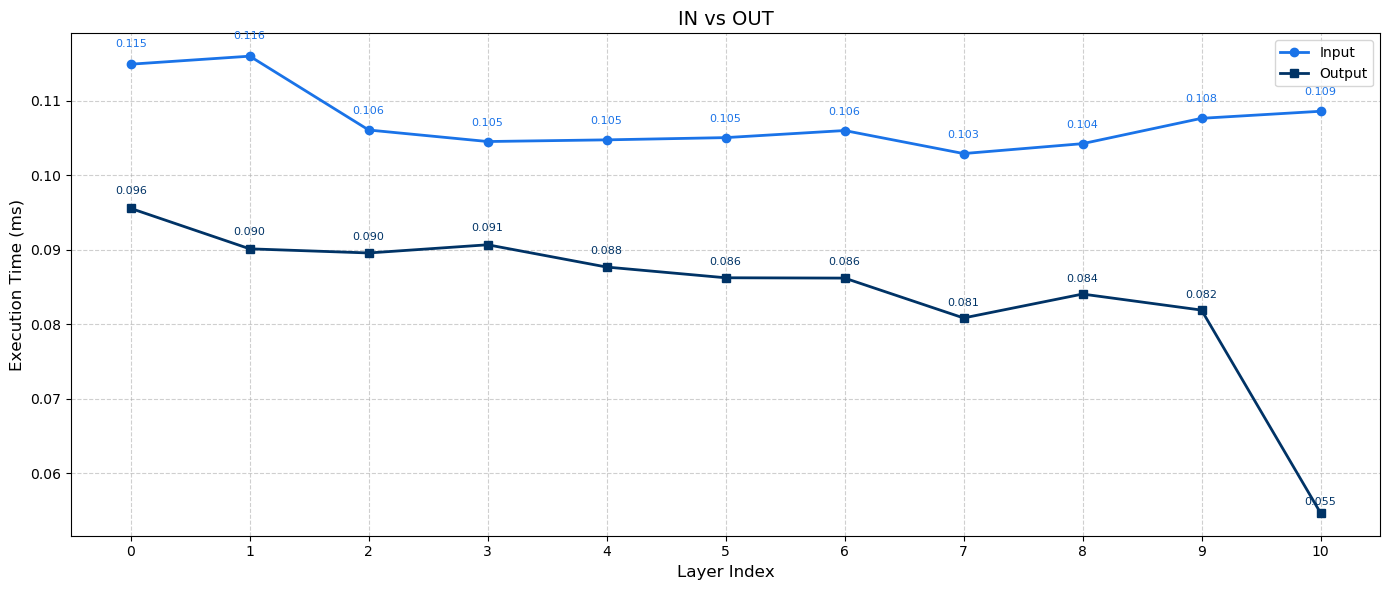

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 폴더 경로
csv_dir = "/home/avees/tee/graph/component/src"

# 색상 설정 (dark blue 계열)
colors = ['#1a73e8', '#003366']  # 두 개 그래프용 색상

# 🔹 범례(legend) 이름 직접 지정
legend_labels = {
    "INFER.csv": "TEE",
    "LAYER.csv": "REE",
    "IN.csv": "Input",
    "OUT.csv": "Output",
}

# 파일 그룹 정의
group_pairs = [
    ("INFER.csv", "LAYER.csv", "INFER vs LAYER"),
    ("IN.csv", "OUT.csv", "IN vs OUT"),
]

for file1, file2, title in group_pairs:
    path1 = os.path.join(csv_dir, file1)
    path2 = os.path.join(csv_dir, file2)

    # 두 파일 모두 존재하는지 확인
    if not (os.path.exists(path1) and os.path.exists(path2)):
        print(f"⚠️  Skipping {title}: one or both files missing")
        continue

    # CSV 읽기
    df1 = pd.read_csv(path1, index_col=0)
    df2 = pd.read_csv(path2, index_col=0)

    # avg 행만 추출
    if 'avg' not in df1.index or 'avg' not in df2.index:
        print(f"⚠️  Skipping {title}: 'avg' row missing")
        continue

    avg1 = df1.loc['avg']
    avg2 = df2.loc['avg']

    # x축: Layer index (숫자)
    x1 = np.arange(len(avg1))
    x2 = np.arange(len(avg2))

    plt.figure(figsize=(14, 6))

    # 🔹 legend 이름 지정
    label1 = legend_labels.get(file1, file1.replace('.csv', ''))
    label2 = legend_labels.get(file2, file2.replace('.csv', ''))

    # 꺾은선그래프
    plt.plot(x1, avg1.values, marker='o', linestyle='-', color=colors[0], linewidth=2, label=label1)
    plt.plot(x2, avg2.values, marker='s', linestyle='-', color=colors[1], linewidth=2, label=label2)

    # 각 점 위에 값 표시
    for i, v in enumerate(avg1.values):
        plt.text(i, v + (v * 0.02), f"{v:.3f}", ha='center', fontsize=8, color=colors[0])
    for i, v in enumerate(avg2.values):
        plt.text(i, v + (v * 0.02), f"{v:.3f}", ha='center', fontsize=8, color=colors[1])

    # 시각적 설정
    plt.title(f"{title}", fontsize=14)
    plt.xlabel("Layer Index", fontsize=12)
    plt.ylabel("Execution Time (ms)", fontsize=12)
    plt.xticks(x1)  # x축을 0,1,2,... 형태로 표시
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [16]:
import os
import pandas as pd

# CSV 폴더 경로
csv_dir = "/home/avees/tee/output/tee_time"
output_path = os.path.join(csv_dir, "merged.csv")

# 모든 CSV를 담을 리스트
all_dfs = []

# 디렉토리 내 모든 CSV 파일 순회
for filename in sorted(os.listdir(csv_dir)):
    if filename.endswith(".csv"):
        csv_path = os.path.join(csv_dir, filename)
        df = pd.read_csv(csv_path)

        # 파일명(확장자 제외) 저장용 열 추가
        df.insert(0, "source", os.path.splitext(filename)[0])

        # DataFrame 리스트에 추가
        all_dfs.append(df)

# 모든 CSV 병합 (아래로 concat)
merged_df = pd.concat(all_dfs, ignore_index=True)

# 병합된 CSV 저장
merged_df.to_csv(output_path, index=False)

print(f"✅ 모든 CSV 파일을 병합하여 저장했습니다: {output_path}")
print(f"총 행 개수: {len(merged_df)}")


ValueError: cannot insert source, already exists

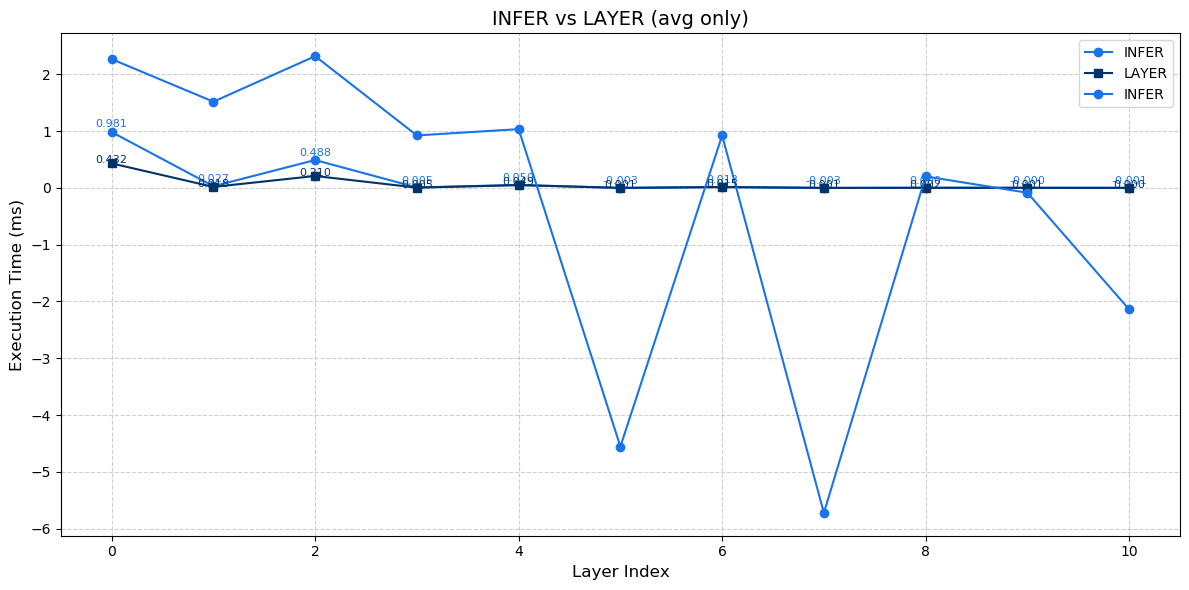

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 폴더 경로
csv_dir = "/home/avees/tee/graph/component/src"

# 색상 설정 (dark blue 계열)
colors = ['#1a73e8', '#003366']  # INFER/LAYER, IN/OUT 각각 구분용

# 파일 그룹 정의
group_pairs = [
    ("INFER.csv", "LAYER.csv", "INFER vs LAYER"),
]

for file1, file2, title in group_pairs:
    path1 = os.path.join(csv_dir, file1)
    path2 = os.path.join(csv_dir, file2)

    # 두 파일 모두 존재하는지 확인
    if not (os.path.exists(path1) and os.path.exists(path2)):
        print(f"⚠️  Skipping {title}: one or both files missing")
        continue

    # CSV 읽기
    df1 = pd.read_csv(path1, index_col=0)
    df2 = pd.read_csv(path2, index_col=0)

    # avg 행만 추출
    if 'avg' not in df1.index or 'avg' not in df2.index:
        print(f"⚠️  Skipping {title}: 'avg' row missing")
        continue

    avg1 = df1.loc['avg']
    avg2 = df2.loc['avg']

    # 그래프 설정
    plt.figure(figsize=(12, 6))
    x1 = np.arange(len(avg1))
    x2 = np.arange(len(avg2))

    plt.plot(x1, avg1.values-0.065, marker='o', linestyle='-', color=colors[0], label=file1.replace('.csv', ''))
    plt.plot(x2, avg2.values, marker='s', linestyle='-', color=colors[1], label=file2.replace('.csv', ''))
    plt.plot(x1, (avg1.values-0.068) / avg2.values, marker='o', linestyle='-', color=colors[0], label=file1.replace('.csv', ''))

    # 값 표시
    for i, v in enumerate(avg1.values):
        plt.text(i, v + (v * 0.02), f"{v-0.068:.3f}", ha='center', fontsize=8, color=colors[0])
    for i, v in enumerate(avg2.values):
        plt.text(i, v + (v * 0.02), f"{v:.3f}", ha='center', fontsize=8, color=colors[1])

    # 시각적 설정
    plt.title(f"{title} (avg only)", fontsize=14)
    plt.xlabel("Layer Index", fontsize=12)
    plt.ylabel("Execution Time (ms)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


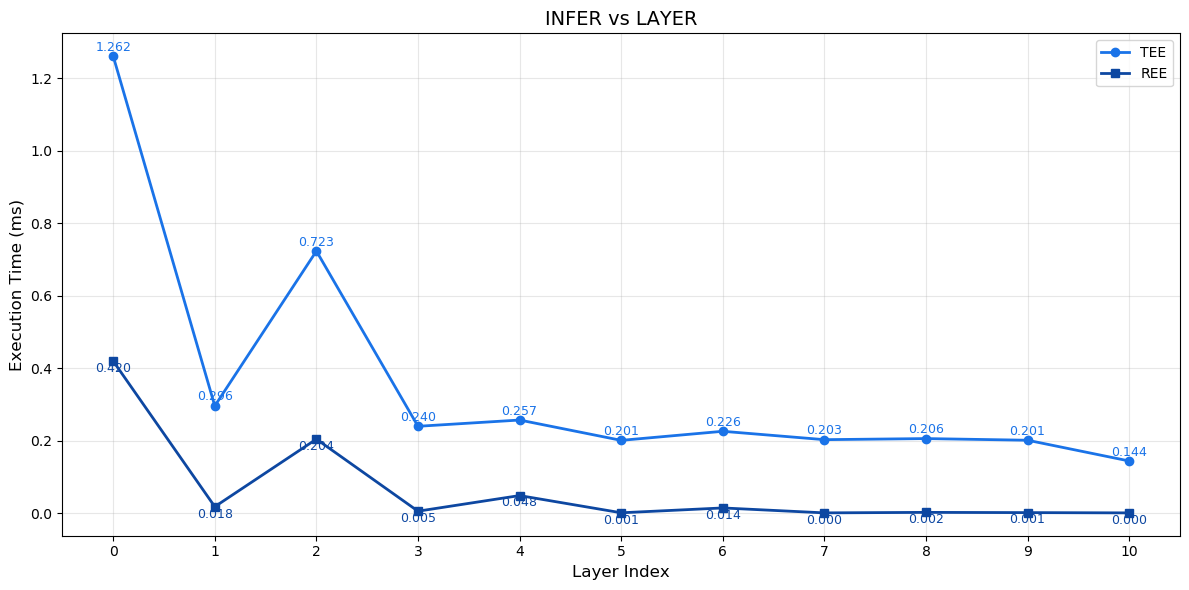

✅ 그래프 저장 완료: /home/avees/tee/output/tee_layer_line_comparison.png


In [18]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 파일 경로
csv_path = "/home/avees/tee/output/output_merged.csv"

# CSV 읽기
df = pd.read_csv(csv_path)
df.rename(columns={"mean(exclude_max)": "mean"}, inplace=True)

# 🔹 TEE, LAYER만 필터링 (대소문자 무시)
df = df[df["label"].str.contains("TEE|LAYER", case=False, na=False)].copy()

# 🔹 index 추출 함수
def extract_index(label):
    label = label.upper()
    # TEE[a-a] → a
    m1 = re.search(r"TEE\[(\d+)-\1\]", label)
    # LAYER[a] 또는 LAYER[a-a] → a
    m2 = re.search(r"LAYER\[(\d+)(?:-\1)?\]", label)
    if m1:
        return int(m1.group(1))
    elif m2:
        return int(m2.group(1))
    return None

df["index"] = df["label"].apply(extract_index)
df = df.dropna(subset=["index"]).copy()
df["index"] = df["index"].astype(int)

# 🔹 분리
tee_df = df[df["label"].str.contains("TEE", case=False)]
layer_df = df[df["label"].str.contains("LAYER", case=False)]

# 🔹 X축 범위 0~10
x_labels = list(range(0, 11))
x = np.arange(len(x_labels))

tee_y, layer_y = [], []

for i in x_labels:
    tee_row = tee_df[tee_df["index"] == i]
    layer_row = layer_df[layer_df["index"] == i]
    tee_val = tee_row["mean"].values[0] if not tee_row.empty else np.nan
    layer_val = layer_row["mean"].values[0] if not layer_row.empty else np.nan
    tee_y.append(tee_val)
    layer_y.append(layer_val)

# 🔹 그래프
plt.figure(figsize=(12, 6))
plt.plot(x, tee_y, marker='o', color="#1a73e8", label='TEE', linewidth=2)
plt.plot(x, layer_y, marker='s', color="#0d47a1", label='REE', linewidth=2)

# 각 점에 수치 표시
for i, (ty, ly) in enumerate(zip(tee_y, layer_y)):
    if not np.isnan(ty):
        plt.text(i, ty + 0.015, f"{ty:.3f}", color="#1a73e8", ha='center', fontsize=9)
    if not np.isnan(ly):
        plt.text(i, ly - 0.03, f"{ly:.3f}", color="#0d47a1", ha='center', fontsize=9)

# 설정
plt.xticks(x, x_labels)
plt.xlabel("Layer Index", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)
plt.title("INFER vs LAYER", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# 저장
output_png = os.path.join(os.path.dirname(csv_path), "tee_layer_line_comparison.png")
plt.savefig(output_png, dpi=300)
plt.show()

print(f"✅ 그래프 저장 완료: {output_png}")


✅ IN 라벨 개수: 11
✅ OUT 라벨 개수: 11


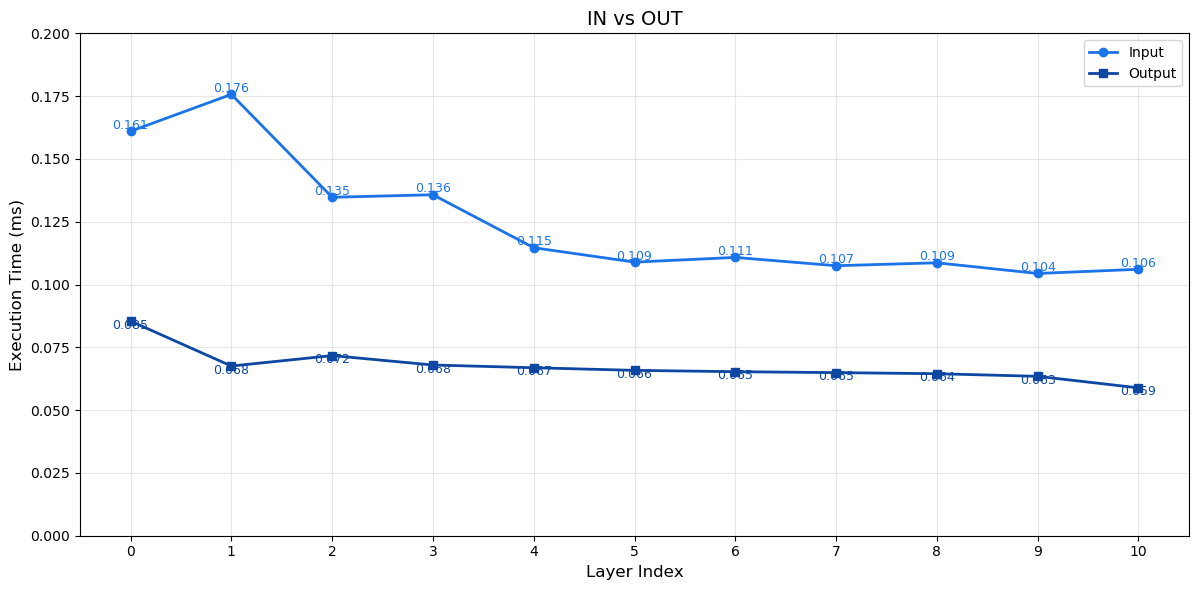

✅ 그래프 저장 완료: /home/avees/tee/output/in_out_line_comparison_fixed.png


In [23]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 파일 경로
csv_path = "/home/avees/tee/output/output_merged.csv"

# CSV 읽기
df = pd.read_csv(csv_path)
df.rename(columns={"mean(exclude_max)": "mean"}, inplace=True)

# 🔹 IN, OUT만 필터링 (대소문자 무시)
df = df[df["label"].str.contains("IN|OUT", case=False, na=False)].copy()

# 🔹 index 추출 (IN[0], OUT[0] 형식)
def extract_index(label):
    label = label.upper()
    m = re.search(r"(?:IN|OUT)\[(\d+)\]", label)
    if m:
        return int(m.group(1))
    return None

df["index"] = df["label"].apply(extract_index)
df = df.dropna(subset=["index"]).copy()
df["index"] = df["index"].astype(int)

# 🔹 분리
in_df = df[df["label"].str.contains("IN", case=False)]
out_df = df[df["label"].str.contains("OUT", case=False)]

print(f"✅ IN 라벨 개수: {len(in_df)}")
print(f"✅ OUT 라벨 개수: {len(out_df)}")

# 🔹 X축 (0~10)
x_labels = sorted(set(df["index"]))
x = np.arange(len(x_labels))

in_y, out_y = [], []

for i in x_labels:
    in_row = in_df[in_df["index"] == i]
    out_row = out_df[out_df["index"] == i]
    in_val = in_row["mean"].values[0] if not in_row.empty else np.nan
    out_val = out_row["mean"].values[0] if not out_row.empty else np.nan
    in_y.append(in_val)
    out_y.append(out_val)

# 🔹 그래프
plt.figure(figsize=(12, 6))
plt.plot(x, in_y, marker='o', color="#1a73e8", label='Input', linewidth=2)
plt.plot(x, out_y, marker='s', color="#0d47a1", label='Output', linewidth=2)

# 🔹 점 위에 수치 표시
for i, (iy, oy) in enumerate(zip(in_y, out_y)):
    if not np.isnan(iy):
        plt.text(i, iy + 0.001, f"{iy:.3f}", color="#1a73e8", ha='center', fontsize=9)
    if not np.isnan(oy):
        plt.text(i, oy - 0.003, f"{oy:.3f}", color="#0d47a1", ha='center', fontsize=9)

# 🔹 그래프 설정
plt.xticks(x, x_labels)
plt.xlabel("Layer Index", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)
plt.title("IN vs OUT", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.ylim(0,.2)
# 저장
output_png = os.path.join(os.path.dirname(csv_path), "in_out_line_comparison_fixed.png")
plt.savefig(output_png, dpi=300)
plt.show()

print(f"✅ 그래프 저장 완료: {output_png}")


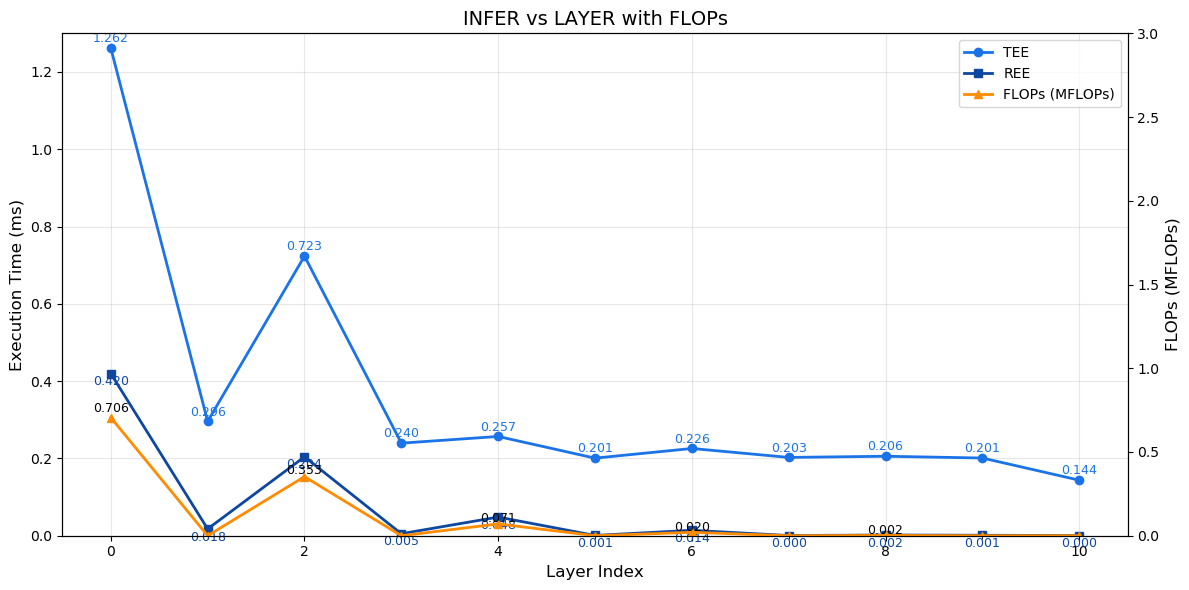

✅ 그래프 저장 완료: /home/avees/tee/output/tee_layer_line_with_flops.png


In [9]:
# ... (위쪽 동일)

# ============================
#          그래프
# ============================
fig, ax1 = plt.subplots(figsize=(12, 6))

# (좌측 y축) 실행시간
l1, = ax1.plot(x, tee_y, marker='o', color="#1a73e8", label='TEE', linewidth=2)
l2, = ax1.plot(x, layer_y, marker='s', color="#0d47a1", label='REE', linewidth=2)

# 실행시간 수치 표기
for i, (ty, ly) in enumerate(zip(tee_y, layer_y)):
    if not np.isnan(ty):
        ax1.text(i, ty + 0.015, f"{ty:.3f}", color="#1a73e8", ha='center', fontsize=9)
    if not np.isnan(ly):
        ax1.text(i, ly - 0.03, f"{ly:.3f}", color="#0d47a1", ha='center', fontsize=9)

ax1.set_xlabel("Layer Index", fontsize=12)
ax1.set_ylabel("Execution Time (ms)", fontsize=12)
ax1.set_ylim(0, 1.3)  # ✅ 우측 y축 최대값 1.0
ax1.set_xticks(x, x_labels)
ax1.grid(alpha=0.3)

# (우측 y축) FLOPs (오렌지색 실선)
ax2 = ax1.twinx()
l3, = ax2.plot(x, flops_mflops, marker='^', linewidth=2, color="#ff8c00",
               label='FLOPs (MFLOPs)')  # ✅ 오렌지색 실선
ax2.set_ylabel("FLOPs (MFLOPs)", fontsize=12)
ax2.set_ylim(0, 3)  # ✅ 우측 y축 최대값 1.0

# FLOPs 수치 표기
for i, fy in enumerate(flops_mflops):
    if fy > 0:
        ax2.text(i, min(0.98, fy + max(0.01, fy*0.05)), f"{fy:.3f}", ha='center', fontsize=9)

# 범례(두 축 합치기)
lines = [l1, l2, l3]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title("INFER vs LAYER with FLOPs", fontsize=14)
plt.tight_layout()

# 저장 경로만 바꾸고 싶으면 아래 파일명 수정하세요.
output_png = os.path.join(os.path.dirname(csv_path), "tee_layer_line_with_flops.png")
plt.savefig(output_png, dpi=300)
plt.show()

print(f"✅ 그래프 저장 완료: {output_png}")


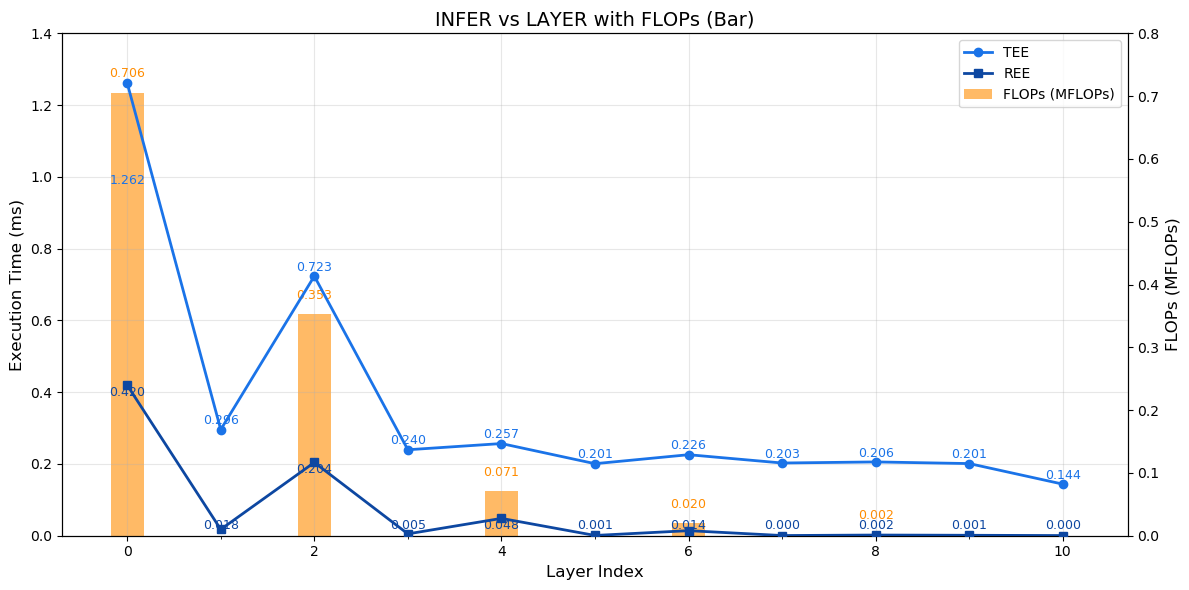

✅ 그래프 저장 완료: /home/avees/tee/output/tee_layer_line_with_flops_bar.png


In [18]:
# ... (위쪽 동일: 데이터 전처리/tee_y, layer_y, flops_mflops 계산까지)

# ============================
#          그래프
# ============================
fig, ax1 = plt.subplots(figsize=(12, 6))

# (좌측 y축) 실행시간 라인
l1, = ax1.plot(x, tee_y, marker='o', color="#1a73e8", label='TEE', linewidth=2, zorder=3, alpha=1)
l2, = ax1.plot(x, layer_y, marker='s', color="#0d47a1", label='REE', linewidth=2, zorder=3, alpha=1)

# 실행시간 수치 표기 (y=1.0 상한 넘지 않도록 클램프)
for i, (ty, ly) in enumerate(zip(tee_y, layer_y)):
    if not np.isnan(ty):
        ax1.text(i, min(0.98, ty + 0.015), f"{ty:.3f}", color="#1a73e8", ha='center', fontsize=9, zorder=4)
    if not np.isnan(ly):
        ax1.text(i, max(0.02, ly - 0.03), f"{ly:.3f}", color="#0d47a1", ha='center', fontsize=9, zorder=4)

ax1.set_xlabel("Layer Index", fontsize=12)
ax1.set_ylabel("Execution Time (ms)", fontsize=12)
ax1.set_xticks(x, x_labels)
ax1.grid(alpha=0.3, zorder=1)
ax1.set_ylim(0, 1.4)          # ✅ 좌측 y축 0~1.0

# (우측 y축) FLOPs 막대 (오렌지색)
ax2 = ax1.twinx()
bar_width = 0.35
l3 = ax2.bar(x, flops_mflops, width=bar_width, align='center',
             color="#ff8c00", alpha=0.6, label='FLOPs (MFLOPs)', zorder=0)  # ✅ 오렌지 바
ax2.set_ylabel("FLOPs (MFLOPs)", fontsize=12)
ax2.set_ylim(0, 0.8)          # ✅ 우측 y축 0~1.0

# FLOPs 막대 위 수치
for i, fy in enumerate(flops_mflops):
    if fy > 0:
        ax2.text(i, min(0.98, fy + 0.02), f"{fy:.3f}", ha='center', va='bottom',
                 fontsize=9, color="#ff8c00", zorder=4)

# 범례(두 축 합치기) — bar는 첫 패치로 대표
lines = [l1, l2, l3.patches[0]]
labels = [ln.get_label() for ln in [l1, l2]] + ['FLOPs (MFLOPs)']
ax1.legend(lines, labels, loc='upper right')

plt.title("INFER vs LAYER with FLOPs (Bar)", fontsize=14)
plt.tight_layout()
ax2.set_zorder(1)          # 바(axis)를 뒤로
ax1.set_zorder(2)  
ax1.patch.set_alpha(0)
# 저장
output_png = os.path.join(os.path.dirname(csv_path), "tee_layer_line_with_flops_bar.png")
plt.savefig(output_png, dpi=300)
plt.show()

print(f"✅ 그래프 저장 완료: {output_png}")
